In [1]:
import pyhf
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

In [2]:
class custom_modifier_add:
    op_code = 'addition'
    name = 'custom_modifier_add'

    def __init__(self, name='name'):
        self.required_parsets = {
            'mean': [
                {
                    'paramset_type': pyhf.parameters.paramsets.unconstrained,
                    'n_parameters': 1,
                    'is_constrained': False,
                    'is_shared': True,
                    'inits': (0.0,),
                    'bounds': ((-5, 5),),
                    'fixed': False,
                }
            ]
        }

    def apply(self, pars):
        base = np.zeros(
            (1, len(m.config.samples), 1, sum(m.config.channel_nbins.values()))
        )

        bins = np.linspace(-5, 5, 20 + 1)
        mean = pars[self.config.par_slice('mean')][0]
        yields = 100 * (
            scipy.stats.norm(loc=mean).cdf(bins[1:])
            - scipy.stats.norm(loc=mean).cdf(bins[:-1])
        )
        base[0, self.config.samples.index('signal'), 0, :] = yields
        return base


class custom_modifier_mult:
    op_code = 'multiplication'
    name = 'custom_modifier_mult'

    def __init__(self, name='name'):
        self.required_parsets = {
            'mean': [
                {
                    'paramset_type': pyhf.parameters.paramsets.unconstrained,
                    'n_parameters': 1,
                    'is_constrained': False,
                    'is_shared': True,
                    'inits': (0.0,),
                    'bounds': ((-5, 5),),
                    'fixed': False,
                }
            ]
        }

    def apply(self, pars):
        base = np.ones(
            (1, len(m.config.samples), 1, sum(m.config.channel_nbins.values()))
        )

        bins = np.linspace(-5, 5, 20 + 1)
        mean = pars[self.config.par_slice('mean')][0]
        yields = 100 * (
            scipy.stats.norm(loc=mean).cdf(bins[1:])
            - scipy.stats.norm(loc=mean).cdf(bins[:-1])
        )
        base[0, self.config.samples.index('signal'), 0, :] = yields
        return base


m = pyhf.Model(
    {
        'channels': [
            {
                'name': 'singlechannel',
                'samples': [
                    {
                        'name': 'signal',
                        'data': [0] * 20,
                        'modifiers': [
                            {'name': 'mu', 'type': 'normfactor', 'data': None}
                        ],
                    },
                    {'name': 'background', 'data': [300] * 20, 'modifiers': []},
                ],
            }
        ]
    },
    custom_modifiers=[custom_modifier_add()],
    poi_name='mu',
)
bp = pyhf.tensorlib.astensor(m.config.suggested_init())
bp[m.config.poi_index] = 5
bp[m.config.par_slice('mean')] = [3.0]
d = m.make_pdf(bp).sample()

In [3]:
bestfit = pyhf.infer.mle.fit(d, m)
print(bestfit[m.config.par_slice('mean')])
print(bestfit[m.config.par_slice('mu')])

[2.88586874]
[5.97455269]


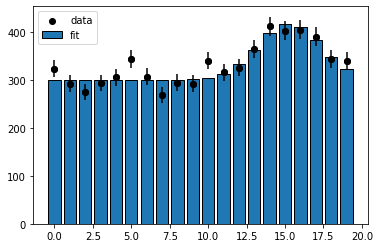

In [4]:
plt.bar(
    np.arange(20),
    m.expected_actualdata(bestfit),
    alpha=1.0,
    facecolor=None,
    edgecolor='k',
    label='fit',
)
plt.scatter(
    np.arange(20),
    d[: m.config.nmaindata],
    alpha=1.0,
    marker='o',
    c='k',
    label='data',
    zorder=99,
)
plt.errorbar(
    np.arange(20),
    d[: m.config.nmaindata],
    yerr=np.sqrt(d[: m.config.nmaindata]),
    marker='o',
    c='k',
    linestyle='',
)
plt.legend()

In [ ]:
s